Check the EDA notebook <a href = "https://www.kaggle.com/daenys2000/global-wheat-detection-eda">here</a>.<br>
Code has been adapted for the wheat dataset using this <a href = "https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html">tutorial</a>.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as alb
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import SubsetRandomSampler
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
import cv2
from tqdm.notebook import tqdm
import torch.nn as nn


## Prepare the dataset

In [2]:
train_path = '/kaggle/input/global-wheat-detection/train.csv'
train_img_path = '/kaggle/input/global-wheat-detection/train'

In [3]:
train = pd.read_csv(train_path)
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
#append .jpg to image ids for easier handling
train['image_id'] = train['image_id'].apply(lambda x: str(x) + '.jpg')

In [5]:
#separating x,y,w,h into separate columns for convenience
bboxes = np.stack(train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep = ',')))
for i, col in enumerate(['x_min', 'y_min', 'w', 'h']):
    train[col] = bboxes[:,i]

train.drop(columns = ['bbox'], inplace = True)
train.head()

,image_id,width,height,source,x_min,y_min,w,h
0,b6ab77fd7.jpg,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7.jpg,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7.jpg,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7.jpg,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7.jpg,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [6]:
train['bbox_area'] = train['w']*train['h']

In [7]:
#setting thresholds for maximum and minimum areas of boxes
max_area = 100000
min_area = 40

In [8]:
#remove boxes that are too big or small
train_clean = train[(train['bbox_area'] < max_area) & (train['bbox_area'] > min_area)]

In [9]:
#splitting into train and valid ids
train_split = 0.8

image_ids = train_clean['image_id'].unique()
train_ids = image_ids[0:int(train_split*len(image_ids))]
val_ids = image_ids[int(train_split*len(image_ids)):]

print('Length of training ids', len(train_ids))
print('Length of validation ids', len(val_ids))

Length of training ids 2698
Length of validation ids 675


In [10]:
train_df = train_clean[train_clean['image_id'].isin(train_ids)]
valid_df = train_clean[train_clean['image_id'].isin(val_ids)]

In [11]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir,transform = None):
        super().__init__()
        self.df = df
        self.img_ids = df['image_id'].unique()
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx: int):
        image_id = self.img_ids[idx]
        pts = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        boxes = pts[['x_min', 'y_min', 'w', 'h']].values
        
        #convert boxes to x1,y1,x2,y2 format because that is what resnet50 faster cnn in pytorch expects
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #width times height
        area = torch.as_tensor(area, dtype = torch.float32)
        
        # there is only one class
        labels = torch.ones((pts.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((pts.shape[0],), dtype=torch.int32)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            else:
                target['boxes'] = torch.linspace(0,3, steps = 4, dtype = torch.float32)
                target['boxes'] = target['boxes'].reshape(-1,4)
            
            #target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            #target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            #target['boxes'] = torch.tensor(sample['bboxes'], dtype = torch.float32)
            
        return image, target, image_id

In [12]:
#defining the transformations
def get_training_transforms():
    return alb.Compose([
    alb.VerticalFlip(p = 0.5),
    alb.HorizontalFlip(p = 0.5),
    #alb.RandomBrightness(p = 0.5),
    #alb.RandomContrast(p = 0.5),
    ToTensorV2(p = 1.0)
], p=1.0, bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_validation_transforms():
    return alb.Compose([ToTensorV2(p = 1.0)], p = 1.0, bbox_params = alb.BboxParams(format='pascal_voc', label_fields=['labels']))

## Create the Model!

In [13]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= True)

In [14]:
#num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
#in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
# load a pre-trained model for classification and return
# only the features

densenet_net = torchvision.models.densenet169(pretrained=True)
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
modules = list(densenet_net.children())[:-1]
backbone = nn.Sequential(*modules)
backbone.out_channels = 1664

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
#setting up dataloaders 
training_dataset = WheatDataset(train_df, train_img_path, get_training_transforms())
validation_dataset = WheatDataset(valid_df, train_img_path, get_validation_transforms())

train_dataloader = DataLoader(
        training_dataset, batch_size=2, shuffle= True, num_workers=4,
        collate_fn= collate_fn)

valid_dataloader = DataLoader(
        validation_dataset, batch_size=2, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

In [18]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
device

device(type='cuda')

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

In [19]:
images, targets, image_ids = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [20]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()

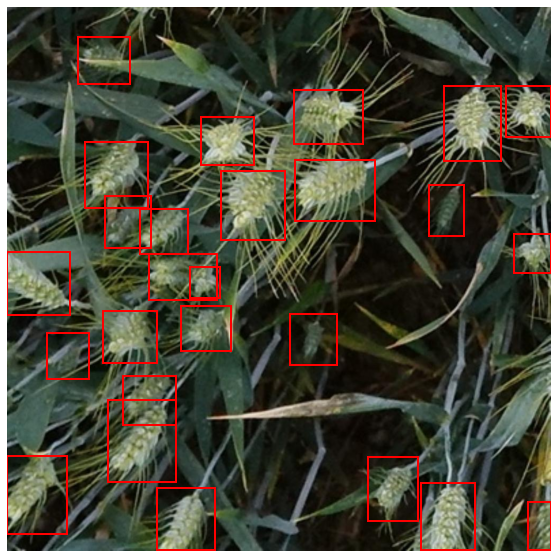

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
ax.set_axis_off()
ax.imshow(img)

## Training

In [22]:
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr= 0.01, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

# and a learning rate scheduler
lr_scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True, threshold=0.0001, threshold_mode='abs', cooldown=0, min_lr=1e-8, eps=1e-08)
# let's train it for 10 epochs
num_epochs = 30

In [23]:
total_train_loss = []
total_test_loss = []
#itr = 1

for epoch in range(num_epochs):
    model.train()

    print('Epoch: ', epoch + 1)
    train_loss = []
    
    for images, targets, image_ids in tqdm(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)  
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        #if itr%50 == 0:
            #print('Iteration: ' + str(itr) + '\n' + 'Loss: '+ str(loss_value))
            
        #itr += 1
        
    epoch_loss = np.mean(train_loss)
    print('Epoch Loss is: ' , epoch_loss)
    total_train_loss.append(epoch_loss)
    
    with torch.no_grad():
        test_losses = []
        for images, targets, image_ids in tqdm(valid_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            test_loss = losses.item()
            test_losses.append(test_loss)
            
    test_losses_epoch = np.mean(test_losses)
    print('Test Loss: ' ,test_losses_epoch)
    total_test_loss.append(test_losses_epoch)
    
    if lr_scheduler is not None:
        lr_scheduler.step(test_losses_epoch)
        
torch.save(model.state_dict(), 'fasterrcnn.pth')

Epoch:  1


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



Epoch Loss is:  0.787062051784029



Test Loss:  0.6522309118826713
Epoch:  2



Epoch Loss is:  0.6086473946906267



Test Loss:  0.5725362301313666
Epoch:  3



Epoch Loss is:  0.5619129780555673



Test Loss:  0.5626829575152087
Epoch:  4



Epoch Loss is:  0.536852094743144



Epoch Loss is:  0.4938517014811532



Epoch Loss is:  0.47739500474540986



Epoch Loss is:  0.46431965267684744



Test Loss:  0.5119625907942388
Epoch:  12



Test Loss:  0.4700836406789235
Epoch:  14



Test Loss:  0.4587236551138071
Epoch:  19



Epoch Loss is:  0.3764207292212832



Test Loss:  0.4668652144585841
Epoch    28: reducing learning rate of group 0 to 3.9063e-05.
Epoch:  29


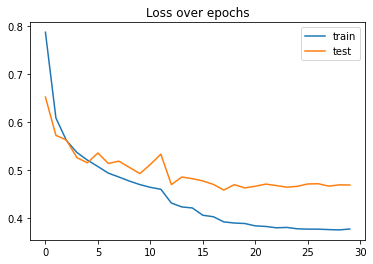

In [24]:
plt.plot(np.arange(num_epochs),total_train_loss ,label = 'train')
plt.plot(np.arange(num_epochs),total_test_loss, label = 'test')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [25]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d

In [26]:
images, targets, image_ids in next(iter(valid_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
images

prediction = model(images)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


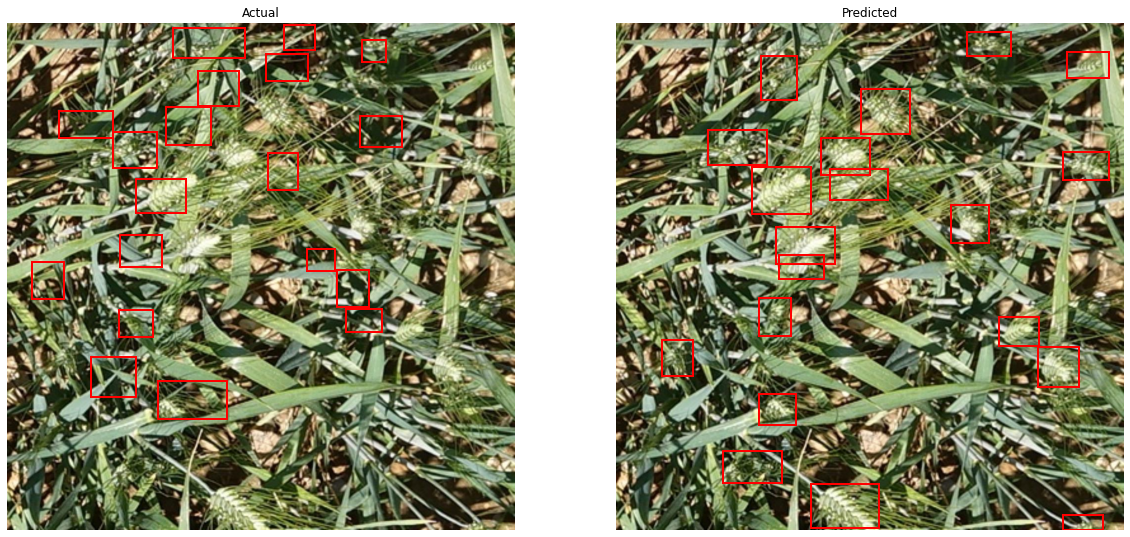

In [27]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()

for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Actual')
ax[0].set_axis_off()
ax[0].imshow(img)

thresh = 0.5
box_preds = prediction[0]['boxes'].cpu().detach().numpy()
score_preds = prediction[0]['scores'].cpu().detach().numpy()
box_preds = box_preds[score_preds >= thresh].astype(np.int32)
for box in box_preds:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Predicted')
ax[1].set_axis_off()
ax[1].imshow(img)